# Ejemplo Utilidad vs Privacidad

La idea central en privacidad diferencial es que existe un trade-off (compromiso) entre privacidad y utilidad. Es decir, para garantizar mayor privacidad se debe agregar más ruido, lo que a su vez reduce la precisión (o utilidad) de la consulta. Una forma teórica de ver esta relación, especialmente en el caso del mecanismo de Laplace, es la siguiente:

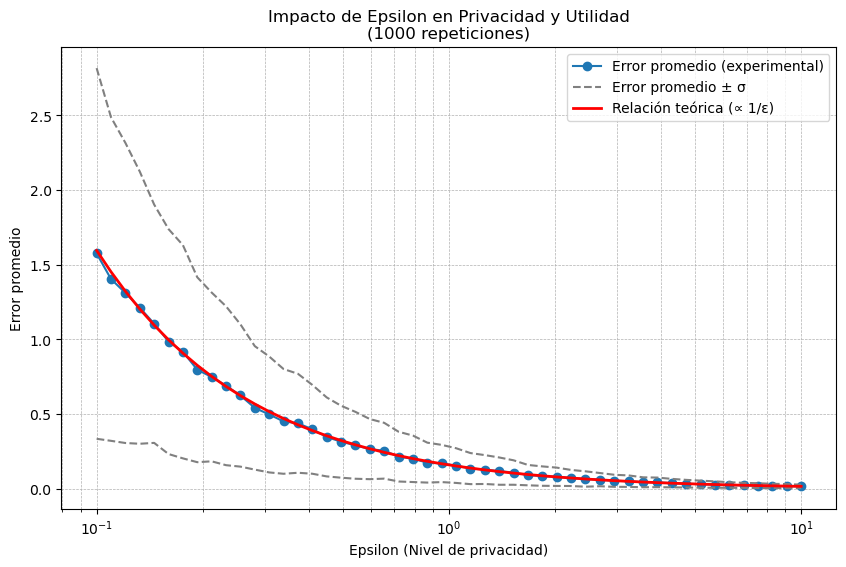

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Función para agregar ruido a cada elemento de los datos usando el mecanismo de Laplace
def add_noise_to_data(data, sensitivity, epsilon):
    """
    Agrega ruido Laplace a cada elemento de los datos.
    
    Parameters:
    - data: array-like, los datos de entrada.
    - sensitivity: float, sensibilidad de cada elemento.
    - epsilon: float, parámetro de privacidad.

    Returns:
    - Array con los datos con ruido agregado.
    """
    scale = sensitivity / epsilon
    noisy_data = data + np.random.laplace(0, scale, size=len(data))
    noisy_data = np.round(noisy_data, 2)
    return noisy_data

# --- Generación de datos ---
# Fijamos la semilla para reproducibilidad del dataset
np.random.seed(42)
data = np.random.randint(18, 80, size=50)  # Edades simuladas de 50 personas
true_mean = np.mean(data)  # Media real de los datos

# --- Parámetros de privacidad y configuración ---
sensitivity = 1  # Sensibilidad para cada elemento
epsilon_values = np.logspace(-1, 1, 50)  # Valores de epsilon entre 0.1 y 10 (escala logarítmica)
num_repeticiones = 1000  # Número de repeticiones para cada epsilon

# Listas para almacenar el error promedio y la desviación estándar para cada epsilon
avg_errors = []
std_errors = []

#print("||   epsilon   || Media original || Error promedio ||")
#print("------------------------------------------------------")

# Para cada valor de epsilon se realizan 100 repeticiones
for epsilon in epsilon_values:
    errores = []
    for rep in range(num_repeticiones):
        # Cada repetición usa el mismo dataset, pero el ruido es distinto en cada llamada.
        noisy_data = add_noise_to_data(data, sensitivity, epsilon)
        noisy_mean = np.mean(noisy_data)
        error = abs(noisy_mean - true_mean)
        errores.append(error)
    errores = np.array(errores)
    avg_error = np.mean(errores)
    std_error = np.std(errores)
    avg_errors.append(avg_error)
    std_errors.append(std_error)
    #print(f"{epsilon:10.3f}      {true_mean:14.2f}      {avg_error:14.3f}")

# Convertir las listas a arrays para facilitar la graficación
avg_errors = np.array(avg_errors)
std_errors = np.array(std_errors)

# --- Línea teórica ---
# Para el query "media" de 50 datos, cada uno con ruido Laplace(0, 1/epsilon),
# la desviación típica del promedio se aproxima a sigma = sqrt(2/(50))/epsilon.
# Aproximamos el valor absoluto esperado (usando el valor absoluto medio de una normal) como:
# E[|error|] ≈ sigma * sqrt(2/π) = (sqrt(2/(50)) * sqrt(2/π)) / epsilon = (2 / sqrt(50*pi)) / epsilon.
constante = 2 / np.sqrt(50 * np.pi)
theoretical_errors = constante / epsilon_values

# --- Graficar resultados ---
plt.figure(figsize=(10, 6))
plt.plot(epsilon_values, avg_errors, marker='o', label="Error promedio (experimental)")
# Líneas punteadas para mostrar el rango (error promedio ± desviación estándar)
plt.plot(epsilon_values, avg_errors + std_errors, '--', color='gray', label="Error promedio ± σ")
plt.plot(epsilon_values, avg_errors - std_errors, '--', color='gray')
# Agregar la línea teórica en rojo
plt.plot(epsilon_values, theoretical_errors, 'r-', linewidth=2, label="Relación teórica (∝ 1/ε)")
plt.xscale('log')
plt.xlabel("Epsilon (Nivel de privacidad)")
plt.ylabel("Error promedio")
plt.title(f"Impacto de Epsilon en Privacidad y Utilidad\n({num_repeticiones} repeticiones)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.show()

#Ejemplo modelo Machine Learning datos pre-privatizados

Vizualizar Conjunto de datos

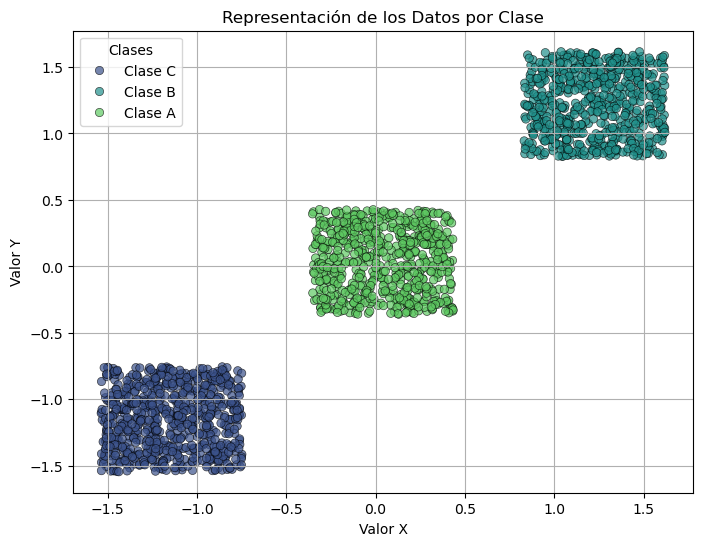

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el dataset
df = pd.read_csv('db/Set_de_Datos_para_Gradient_Descent.csv')
#df = pd.read_csv('/Set_de_Datos_M_s_Homog_neos.csv')

# Crear un scatter plot de los datos
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df["Valor X"], y=df["Valor Y"], hue=df["Etiqueta"], palette="viridis", alpha=0.7, edgecolor='k')

# Configurar etiquetas y título
plt.xlabel("Valor X")
plt.ylabel("Valor Y")
plt.title("Representación de los Datos por Clase")
plt.legend(title="Clases")
plt.grid(True)

# Mostrar el gráfico
plt.show()

Vizualizar Conjunto de datos privatizados con DP

Un epsilon variable y ver como cambian los datos en funcion de este valor

In [34]:
import pandas as pd
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output

# Cargar el dataset original
df = pd.read_csv('db/Set_de_Datos_para_Gradient_Descent.csv')

# Sensibilidad fija
sensitivity = 1.0

# Función para agregar ruido laplaciano
def laplace_noise(value, epsilon, sensitivity):
    scale = sensitivity / epsilon
    noise = np.random.laplace(loc=0, scale=scale)
    return value + noise

df_private_global = None

# Función para actualizar el dataset con un valor de epsilon dinámico y mostrar el gráfico
def update_dataset(epsilon):
    global df_private_global
    df_private = df.copy()
    df_private["Valor X"] = df_private["Valor X"].apply(lambda x: laplace_noise(x, epsilon, sensitivity))
    df_private["Valor Y"] = df_private["Valor Y"].apply(lambda y: laplace_noise(y, epsilon, sensitivity))
    df_private.to_csv("dataset_homogeneous_private.csv", index=False)
    df_private_global = df_private.copy()

    # Limpiar salida anterior y mostrar el dataframe
    clear_output(wait=True)


    # Graficar los datos privatizados
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df_private["Valor X"], y=df_private["Valor Y"], hue=df_private["Etiqueta"], palette="viridis", alpha=0.7, edgecolor='k')
    plt.xlabel("Valor X")
    plt.ylabel("Valor Y")
    plt.title(f"Representación de los datos privatizados (ε={epsilon})")
    plt.legend(title="Clases")
    plt.grid(True)
    plt.show()

# Crear una barra deslizadora para ajustar epsilon
epsilon_slider = widgets.FloatSlider(value=5.0, min=0.1, max=20.0, step=0.1, description='Epsilon')
widgets.interactive(update_dataset, epsilon=epsilon_slider)



interactive(children=(FloatSlider(value=5.0, description='Epsilon', max=20.0, min=0.1), Output()), _dom_classe…

Entrenamiento del modelo con los datos pre-privatizados

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report

# Cargar el dataset 
#df = pd.read_csv('/Set_de_Datos_para_Gradient_Descent.csv')
df_private = df_private_global

# Separar características y etiquetas
X = df_private[["Valor X", "Valor Y"]].values
y = df_private["Etiqueta"].values

# Convertir etiquetas a valores numéricos
y = LabelEncoder().fit_transform(y)

# Normalizar los datos usando MinMaxScaler para mejor estabilidad
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Dividir el dataset en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Crear y entrenar el modelo usando Gradient Descent con mejoras
model = SGDClassifier(loss="modified_huber", max_iter=3000, learning_rate="adaptive", eta0=0.05, penalty="l2", class_weight="balanced", random_state=42)
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.2f}")
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))

# Contar predicciones correctas e incorrectas
correct_predictions = sum(y_pred == y_test)
incorrect_predictions = len(y_test) - correct_predictions
print(f"Predicciones correctas: {correct_predictions}")
print(f"Predicciones incorrectas: {incorrect_predictions}")



Precisión del modelo: 0.97
Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96       130
           1       0.97      1.00      0.98       129
           2       0.96      1.00      0.98       141

    accuracy                           0.97       400
   macro avg       0.98      0.97      0.97       400
weighted avg       0.98      0.97      0.97       400

Predicciones correctas: 390
Predicciones incorrectas: 10


# Ejemplo modelo Machine Learning aplicando DP en el entrenamiento

In [41]:
!pip install opacus


  Using cached opacus-1.5.2-py3-none-any.whl.metadata (7.9 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
Using cached opacus-1.5.2-py3-none-any.whl (239 kB)
Using cached opt_einsum-3.4.0-py3-none-any.whl (71 kB)


In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from opacus import PrivacyEngine
from torch.utils.data import DataLoader, TensorDataset

# Cargar el dataset (reemplazar con archivo real si es necesario)
df_no_DP = df.copy()

# Separar características y etiquetas
X = df_no_DP[["Valor X", "Valor Y"]].values
y = df_no_DP["Etiqueta"].values

# Convertir etiquetas a valores numéricos
y = LabelEncoder().fit_transform(y)

# Normalizar los datos usando MinMaxScaler para mejor estabilidad
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Dividir el dataset en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convertir los datos a tensores de PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Definir batch_size correctamente
batch_size = 64

# Crear DataLoader para PyTorch con el batch_size correcto
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Definir modelo de clasificación simple (Regresión Logística)
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

# Inicializar modelo
input_dim = X_train.shape[1]
output_dim = len(np.unique(y))
model = LogisticRegressionModel(input_dim, output_dim)

# Definir optimizador SGD con privacidad diferencial
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

# Configurar Privacy Engine correctamente para versiones recientes de Opacus
privacy_engine = PrivacyEngine()

model, optimizer, train_loader = privacy_engine.make_private(
    module=model,
    optimizer=optimizer,
    data_loader=train_loader,
    noise_multiplier=1.0,  # Ajusta para mayor o menor privacidad
    max_grad_norm=1.0
)

# Definir función de pérdida
criterion = nn.CrossEntropyLoss()

# Entrenamiento con DP-SGD
epochs = 10
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Obtener presupuesto de privacidad (épsilon y delta)
    epsilon = privacy_engine.get_epsilon(delta=1e-5)
    print(f"Época {epoch+1}/{epochs}, Pérdida: {epoch_loss:.4f}, Épsilon: {epsilon:.2f}")

# Evaluar el modelo
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).argmax(dim=1)

# Calcular métricas
accuracy = accuracy_score(y_test, predictions.numpy())
print(f"\nPrecisión del modelo: {accuracy:.2f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, predictions.numpy()))

# Contar predicciones correctas e incorrectas
correct_predictions = sum(predictions.numpy() == y_test)
incorrect_predictions = len(y_test) - correct_predictions
print(f"\nPredicciones correctas: {correct_predictions}")
print(f"Predicciones incorrectas: {incorrect_predictions}")


C:\Users\smbsa\anaconda3\Lib\site-packages\opacus\privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\smbsa\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Época 1/10, Pérdida: 28.6769, Épsilon: 1.76
Época 2/10, Pérdida: 15.0139, Épsilon: 2.18
Época 3/10, Pérdida: 11.2184, Épsilon: 2.52
Época 4/10, Pérdida: 9.3530, Épsilon: 2.82
Época 5/10, Pérdida: 8.1737, Épsilon: 3.09
Época 6/10, Pérdida: 7.2849, Épsilon: 3.34
Época 7/10, Pérdida: 6.6512, Épsilon: 3.57
Época 8/10, Pérdida: 6.0445, Épsilon: 3.79
Época 9/10, Pérdida: 5.6320, Épsilon: 4.00
Época 10/10, Pérdida: 5.0864, Épsilon: 4.20

Precisión del modelo: 1.00

Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       130
           1       1.00      1.00      1.00       129
           2       1.00      1.00      1.00       141

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400


Predicciones correctas: 400
Predicciones incorrectas: 0


Sin aplicar DP en el entrenamiento

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generar un conjunto de datos sintético
np.random.seed(42)
X_data = np.linspace(-5, 5, 100)
y_data = (X_data - 3) ** 2 + np.random.normal(0, 1, 100)  # Añadiendo algo de ruido

def loss_function(x):
    return (x - 3) ** 2  # Mínimo en x = 3

def gradient(x):
    return 2 * (x - 3)  # Derivada de la función de pérdida

# Inicializar un punto aleatorio
x = np.random.uniform(-5, 5)
learning_rate = 0.1  # Tasa de aprendizaje
num_iterations = 10  # Número de pasos del algoritmo

gx_values = [x]
gloss_values = [loss_function(x)]

# Aplicar el algoritmo de gradient descent sin Differential Privacy
for _ in range(num_iterations):
    grad = gradient(x)  # Calcular gradiente en x
    x = x - learning_rate * grad  # Moverse en dirección contraria al gradiente

    gx_values.append(x)
    gloss_values.append(loss_function(x))

# Graficar el conjunto de datos
plt.figure(figsize=(8, 6))
plt.scatter(X_data, y_data, color='blue', alpha=0.5, label='Datos sintéticos')
plt.plot(X_data, loss_function(X_data), label='Función de Pérdida', color='green')
plt.scatter(gx_values, gloss_values, color='red', marker='o', label='Pasos GD')
plt.xlabel('x')
plt.ylabel('Loss')
plt.title('Descenso de Gradiente')
plt.legend()
plt.grid()
plt.show()

print(f"Valor final encontrado: {x:.4f}")


Aplicando DP en el entrenamiento manualmente

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generar un conjunto de datos sintético
np.random.seed(42)
X_data = np.linspace(-5, 5, 100)
y_data = (X_data - 3) ** 2 + np.random.normal(0, 1, 100)  # Añadiendo algo de ruido

def loss_function(x):
    return (x - 3) ** 2  # Mínimo en x = 3

def gradient(x):
    return 2 * (x - 3)  # Derivada de la función de pérdida

def add_dp_noise(grad, epsilon, sensitivity=1.0):
    scale = sensitivity / epsilon
    noise = np.random.laplace(0, scale)
    return grad + noise

# Inicializar un punto aleatorio
x = np.random.uniform(-5, 5)
learning_rate = 0.1  # Tasa de aprendizaje
num_iterations = 10  # Número de pasos del algoritmo
epsilon = 1.0  # Nivel de privacidad diferencial

gx_values = [x]
gloss_values = [loss_function(x)]

# Aplicar el algoritmo de gradient descent con Differential Privacy
for _ in range(num_iterations):
    grad = gradient(x)  # Calcular gradiente en x
    dp_grad = add_dp_noise(grad, epsilon)  # Agregar ruido para privacidad diferencial
    x = x - learning_rate * dp_grad  # Moverse en dirección contraria al gradiente con DP

    gx_values.append(x)
    gloss_values.append(loss_function(x))

# Graficar el conjunto de datos
plt.figure(figsize=(8, 6))
plt.scatter(X_data, y_data, color='blue', alpha=0.5, label='Datos sintéticos')
plt.plot(X_data, loss_function(X_data), label='Función de Pérdida', color='green')
plt.scatter(gx_values, gloss_values, color='red', marker='o', label='Pasos GD con DP')
plt.xlabel('x')
plt.ylabel('Loss')
plt.title('Descenso de Gradiente con Differential Privacy')
plt.legend()
plt.grid()
plt.show()

print(f"Valor final encontrado con DP: {x:.4f}")

Aplicando DP en el entrenamiento con librerias

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
import tensorflow_privacy as tfp

# Cargar el dataset
df = pd.read_csv("dataset_homogeneous.csv")

# Separar características y etiquetas
X = df[["Valor X", "Valor Y"]].values
y = df["Etiqueta"].values

# Convertir etiquetas a valores numéricos
y = LabelEncoder().fit_transform(y)

# Normalizar los datos usando MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Dividir el dataset en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convertir etiquetas a one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)

# Definir el modelo
model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(2,)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Configurar el optimizador con Differential Privacy
optimizer = tfp.DPKerasSGDOptimizer(
    l2_norm_clip=1.0,  # Clipping para DP
    noise_multiplier=0.5,  # Nivel de privacidad
    num_microbatches=1,  # Tamaño de lotes más pequeños
    learning_rate=0.01
)

# Compilar el modelo
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenar el modelo con DP
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluar el modelo
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f"Precisión del modelo con Differential Privacy: {accuracy:.2f}")
print("Reporte de clasificación:")
print(classification_report(y_test_classes, y_pred_classes))

In [1]:
import os
os.getcwd()


'C:\\Users\\smbsa\\anaconda_projects'